In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from  sklearn.metrics import mean_absolute_percentage_error

In [13]:
def descomposicion(df_train, df_ori):
    decomposition = seasonal_decompose(df_train, model="additive",  period=52)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(10,7))
    plt.subplot(411)
    plt.plot(df_ori, label = "Original", color = "blue")
    plt.legend(loc = "best")
    plt.subplot(412)
    plt.plot(trend, label = "Tendencia", color = "blue")
    plt. legend(loc = "best")
    plt.subplot(413)
    plt.plot(seasonal, label = "Estacionaliedad", color = "blue")
    plt. legend(loc = "best")
    plt.subplot(414)
    plt.plot(residual, label = "Residuos", color = "blue")
    plt. legend(loc = "best")
    plt.show()

In [14]:
def predicciones(n_periodos, modelo, df_train, df_ori, categoria, df_test):
    # Forecast
    #fitted = resultados_sari.get_forecast(n_periodos).predicted_mean
    fitted, confint = modelo.predict(n_periods=n_periodos, return_conf_int=True)
    index_of_fc = pd.date_range(df_train.index[-1], periods = n_periodos, freq='W-SUN')
    #confint = resultados_sari.get_forecast(25).conf_int()
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    # Plot
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(df_ori)
    plt.plot(fitted_series, color='darkgreen')
    plt.plot(lower_series, color='k')
    plt.plot(upper_series, color='k')
    #plt.fill_between(index_of_fc, confint["upper y"].values, confint["lower y"].values, color='k', alpha=.15)
    plt.fill_between(index_of_fc, confint[:, 1], confint[:, 0], color='k', alpha=.15)

    plt.title("SARIMA - Predicción para el número de "+categoria+" en CDMX")
    plt.show()
    
    mape= mean_absolute_percentage_error(df_test[0:n_periodos], fitted)

    print('MAPE: %f' %mape)

In [15]:
def model_plot(df_train, n_periodos, df_ori, categoria, df_test):
    descomposicion(df_train, df_ori) 
    
    model= pm.auto_arima(df_train, 
                      test='adf',
                      seasonal=True,
                      m=52,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

    print(model.summary())
    
    model.plot_diagnostics(figsize = (9,7))
    predicciones(n_periodos, model, df_train, df_ori, categoria, df_test)

## LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO

In [16]:
lesiones_arma = pd.read_csv("../Data/lesiones_arma.csv", parse_dates=["fecha_hechos"])
lesiones_arma.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
lesiones_arma.index = pd.DatetimeIndex(lesiones_arma.fecha_hechos)

lesiones_arma_x_sem = lesiones_arma.resample("W", on = "fecha_hechos").size()
ts_train_lesiones_arma=lesiones_arma_x_sem[lesiones_arma_x_sem.index< "2022-06"]
ts_test_lesiones_arma=lesiones_arma_x_sem[lesiones_arma_x_sem.index>='2022-06']

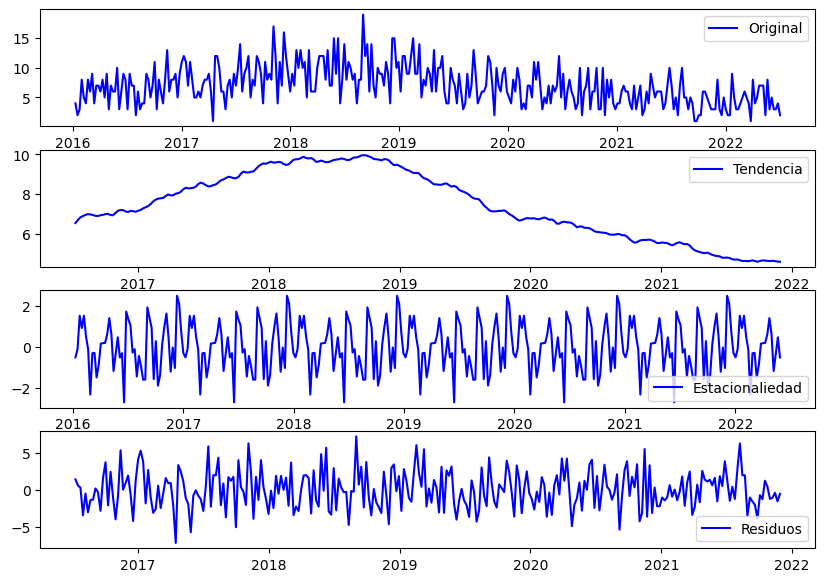

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.74 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1743.729, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1718.698, Time=1.01 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1726.729, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2324.126, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1716.880, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1718.698, Time=0.64 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=1720.709, Time=1.07 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=1702.765, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1704.746, Time=1.33 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=1704.747, Time=0.91 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=1706.746, Time=1.56 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=1699.390, Time=0.10 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=1701.377, Time=1.62 sec
 ARIMA(3,0,0)(0,0,1)[52]

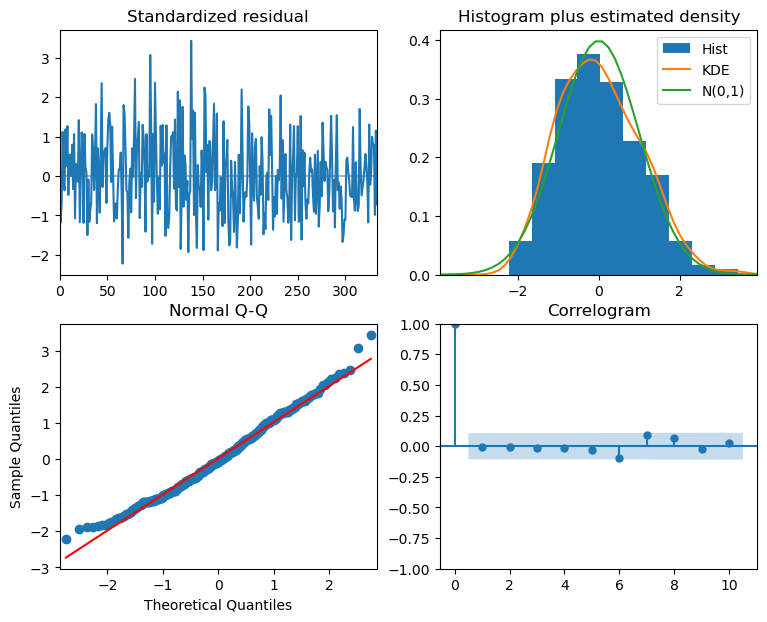

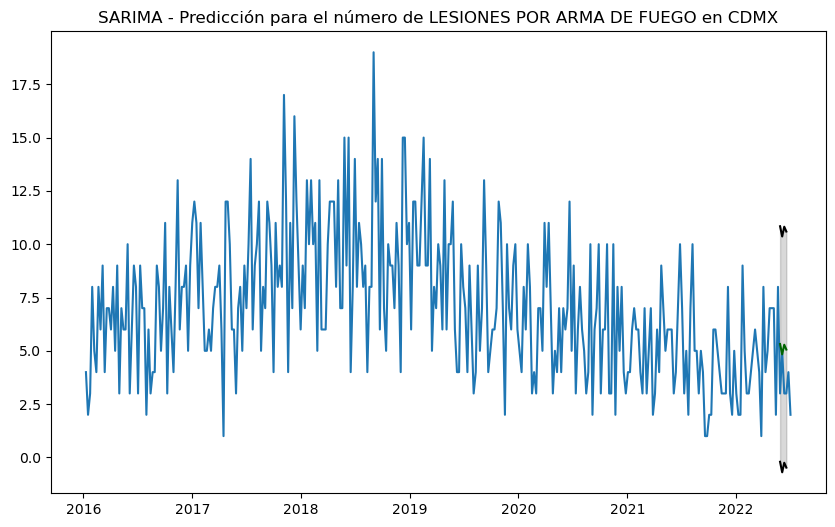

MAPE: 0.425343


In [17]:
model_plot(df_train = ts_train_lesiones_arma, n_periodos = 4, df_ori = lesiones_arma_x_sem, 
           categoria = "LESIONES POR ARMA DE FUEGO", df_test = ts_test_lesiones_arma)

## VIOLACION

In [18]:
violaciones = pd.read_csv("../Data/violaciones.csv", parse_dates=["fecha_hechos"])
violaciones.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
violaciones.index = pd.DatetimeIndex(violaciones.fecha_hechos)

violaciones_x_sem = violaciones.resample("W", on = "fecha_hechos").size()
ts_train_violaciones=violaciones_x_sem[violaciones_x_sem.index<'2022-06']
ts_test_violaciones=violaciones_x_sem[violaciones_x_sem.index>='2022-06']

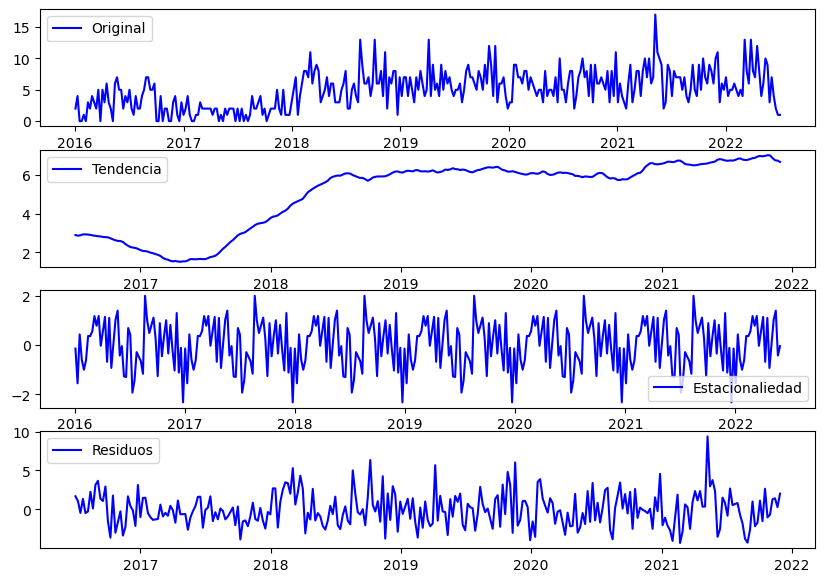

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.63 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1694.781, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1626.952, Time=0.94 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1652.471, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2139.185, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1625.086, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1626.948, Time=0.60 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=1591.168, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1593.168, Time=1.30 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=1593.168, Time=0.78 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.23 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=1573.607, Time=0.09 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=1575.361, Time=1.47 sec
 ARIMA(3,0,0)(0,0,1)[52] intercept

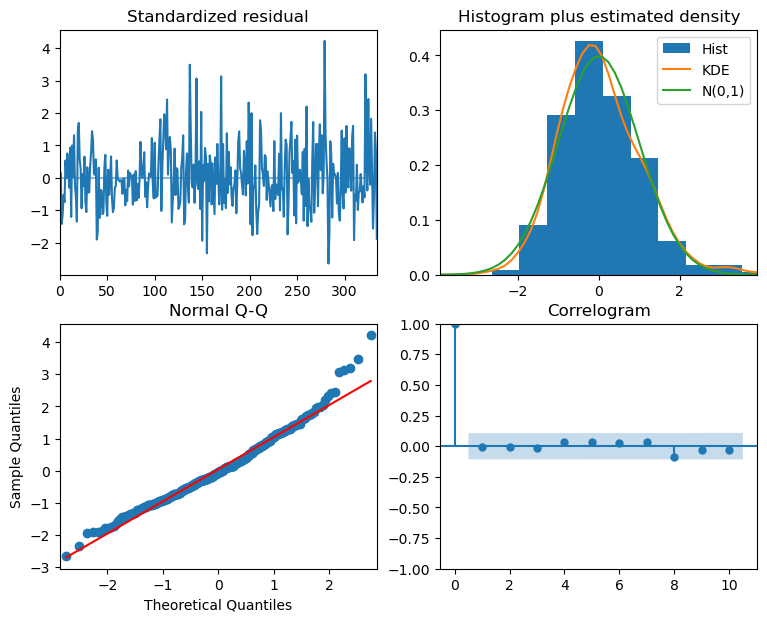

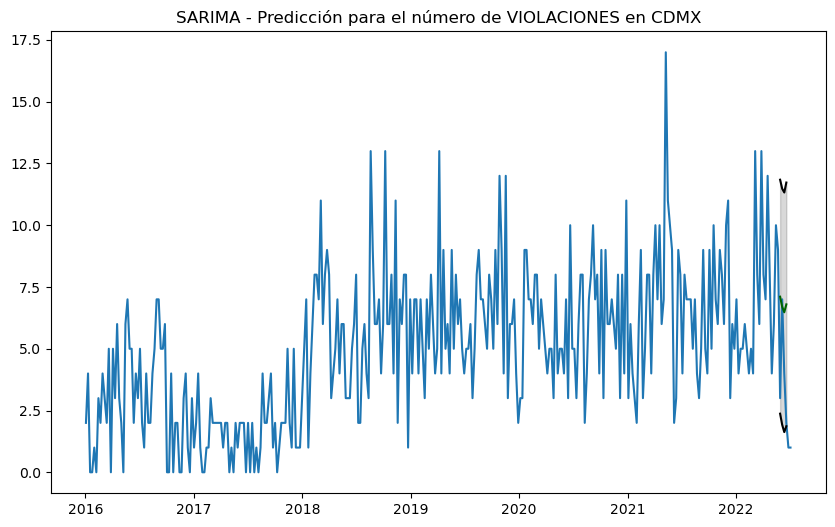

MAPE: 2.180961


In [19]:
model_plot(df_train = ts_train_violaciones, n_periodos = 4, df_ori = violaciones_x_sem, 
           categoria = "VIOLACIONES", df_test = ts_test_violaciones)

## HOMICIDIO DOLOSO

In [22]:
homicidio = pd.read_csv("../Data/homicidios.csv", parse_dates=["fecha_hechos"])
homicidio.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
homicidio.index = pd.DatetimeIndex(homicidio.fecha_hechos)

homicidio_x_sem = homicidio.resample("W", on = "fecha_hechos").size()
ts_train_homicidio=homicidio_x_sem[homicidio_x_sem.index<'2022-06']
ts_test_homicidio=homicidio_x_sem[homicidio_x_sem.index>='2022-06']

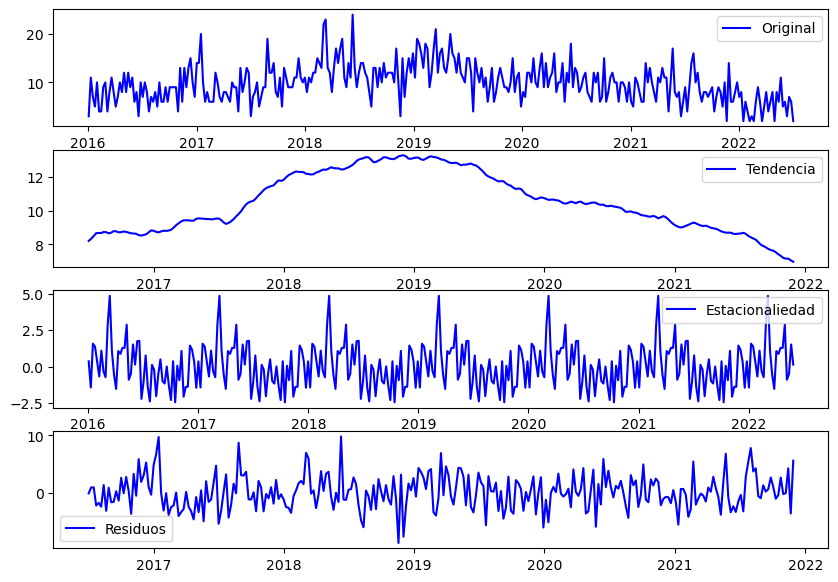

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=1763.154, Time=1.92 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1927.842, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1847.589, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1755.834, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1925.843, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1755.534, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1755.930, Time=0.58 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=1757.746, Time=1.92 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=1757.188, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=1757.176, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1847.519, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=1759.146, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=1753.544, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=1753.939, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1

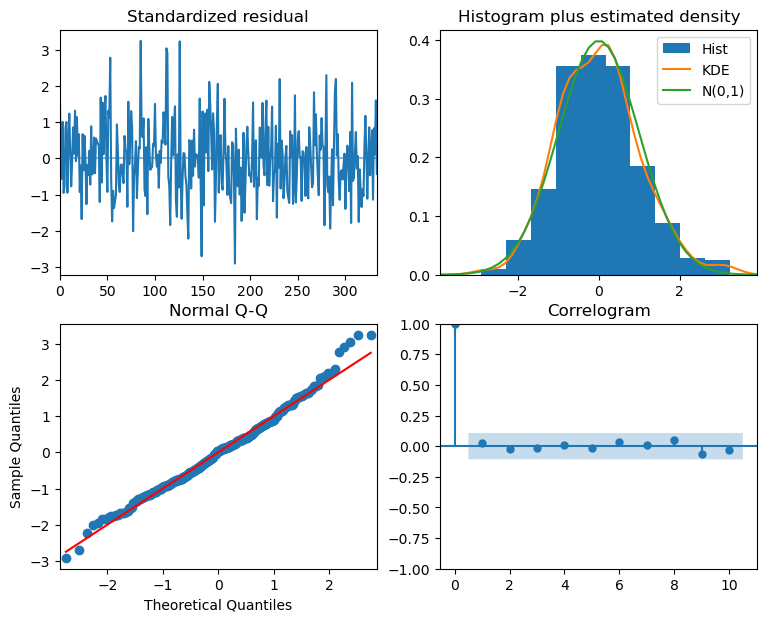

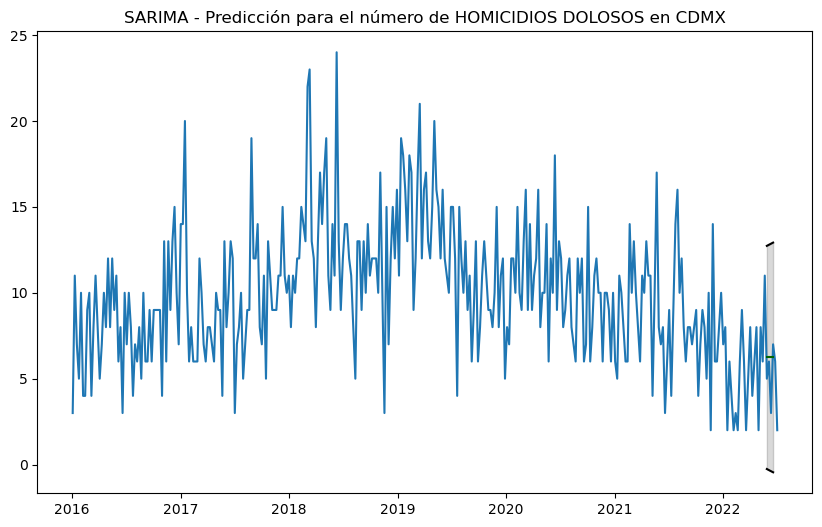

MAPE: 0.316741


In [21]:
model_plot(df_train = ts_train_homicidio, n_periodos = 4, df_ori = homicidio_x_sem, 
           categoria = "HOMICIDIOS DOLOSOS", df_test = ts_test_homicidio)

## ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA

In [23]:
robo_metro = pd.read_csv("../Data/robo_metro.csv", parse_dates=["fecha_hechos"])
robo_metro.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_metro.index = pd.DatetimeIndex(robo_metro.fecha_hechos)

robo_metro_x_sem = robo_metro.resample("W", on = "fecha_hechos").size()
ts_train_robo_metro=robo_metro_x_sem[robo_metro_x_sem.index<'2022-06']
ts_test_robo_metro=robo_metro_x_sem[robo_metro_x_sem.index>='2022-06']

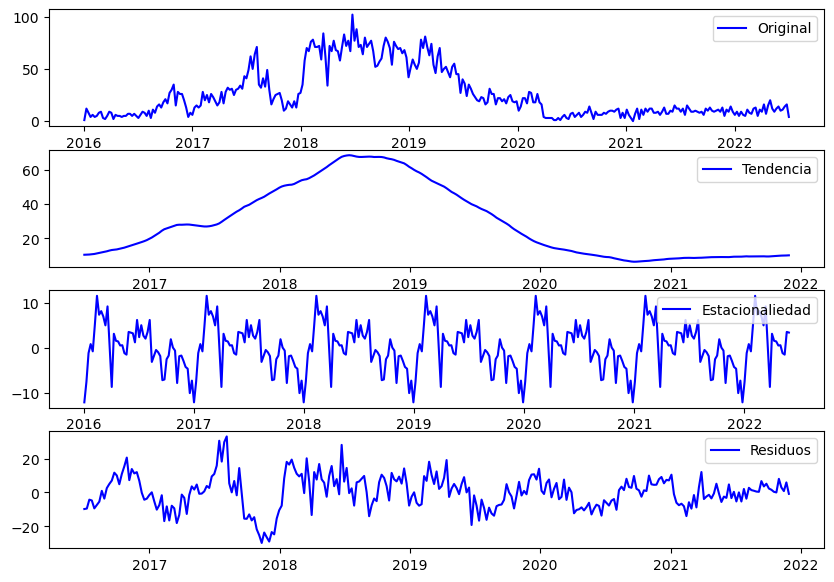

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2312.271, Time=3.44 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2356.584, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2316.061, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2305.262, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2354.591, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2306.868, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2307.182, Time=1.12 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2307.146, Time=2.93 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2305.186, Time=0.62 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2307.181, Time=3.52 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=13.85 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2355.552, Time=0.44 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2307.158, Time=0.86 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=2307.151, Time=0.87 sec
 ARIMA(1,1,2)(1,0,0)[52

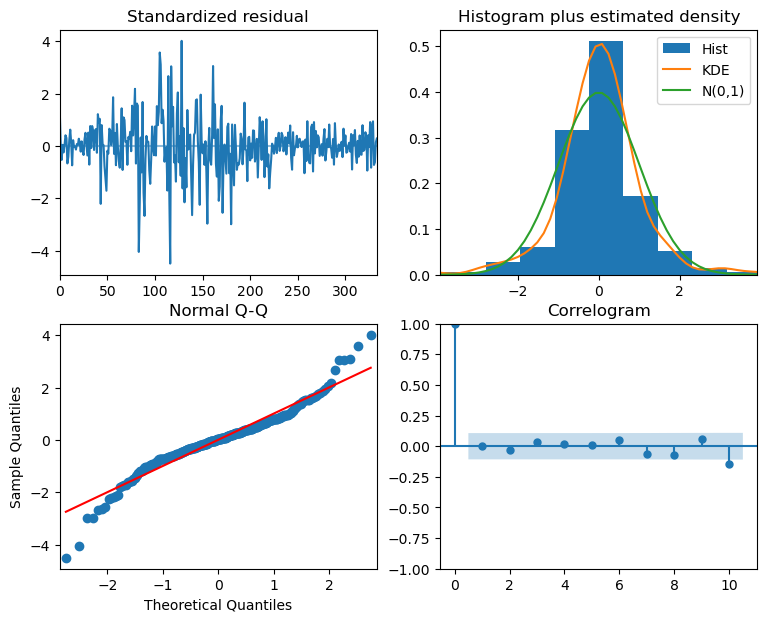

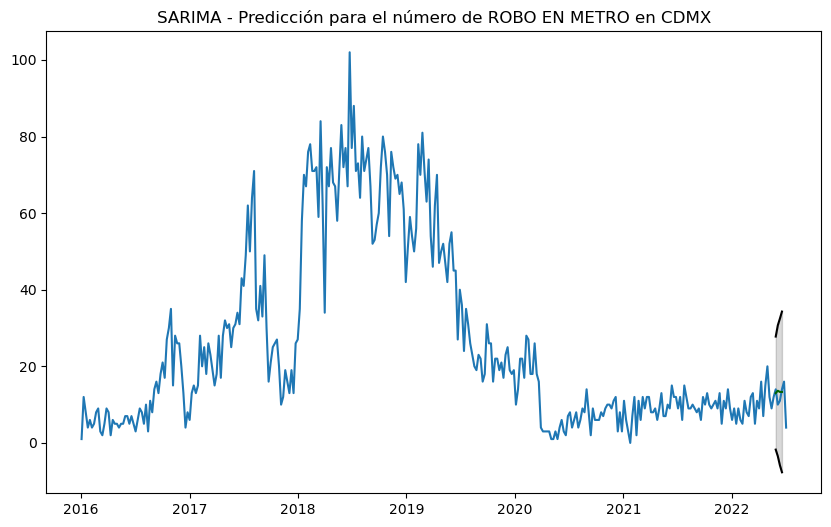

MAPE: 0.188973


In [24]:
model_plot(df_train = ts_train_robo_metro, n_periodos = 4, df_ori = robo_metro_x_sem, 
           categoria = "ROBO EN METRO", df_test = ts_test_robo_metro)

## ROBO A REPARTIDOR CON Y SIN VIOLENCIA

In [25]:
robo_repartidores = pd.read_csv("../Data/robo_repartidores.csv", parse_dates=["fecha_hechos"])
robo_repartidores.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_repartidores.index = pd.DatetimeIndex(robo_repartidores.fecha_hechos)

robo_repartidores_x_sem = robo_repartidores.resample("W", on = "fecha_hechos").size()
ts_train_robo_repartidores=robo_repartidores_x_sem[robo_repartidores_x_sem.index<'2022-06']
ts_test_robo_repartidores=robo_repartidores_x_sem[robo_repartidores_x_sem.index>='2022-06']

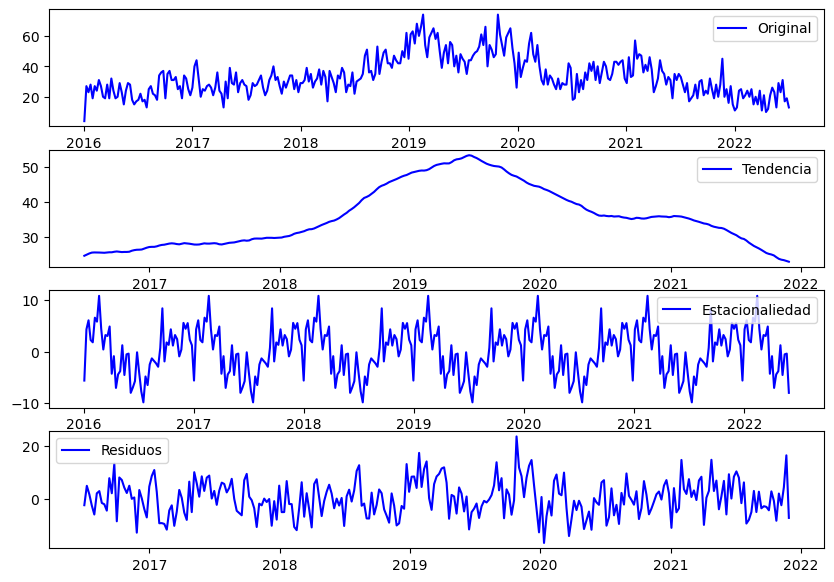

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2298.577, Time=4.34 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2407.109, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2345.852, Time=0.81 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2295.418, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2405.133, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2299.754, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2296.973, Time=1.02 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2296.965, Time=2.98 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2295.073, Time=0.57 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2296.973, Time=3.16 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=7.90 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2404.626, Time=0.47 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2293.857, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2298.425, Time=0.07 sec
 ARIMA(1,1,1)(2,0,0)[52]

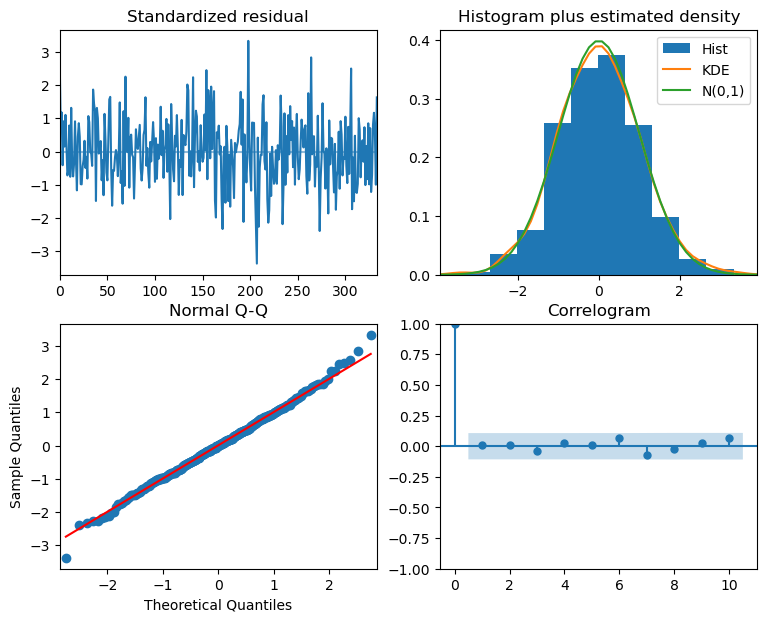

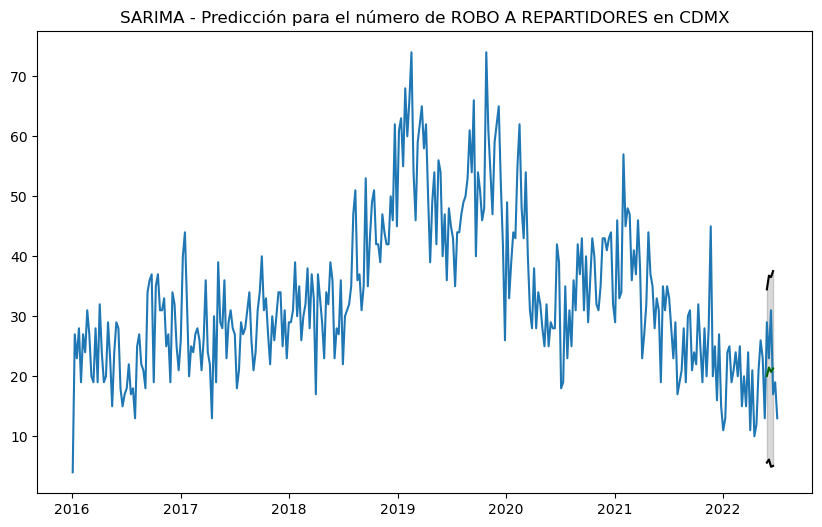

MAPE: 0.194219


In [26]:
model_plot(df_train = ts_train_robo_repartidores, n_periodos = 4, df_ori = robo_repartidores_x_sem, 
           categoria = "ROBO A REPARTIDORES", df_test = ts_test_robo_repartidores)

## ROBO A NEGOCIO CON VIOLENCIA

In [27]:
robo_neg_con = pd.read_csv("../Data/robo_neg_con.csv", parse_dates=["fecha_hechos"])
robo_neg_con.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_neg_con.index = pd.DatetimeIndex(robo_neg_con.fecha_hechos)

robo_neg_con_x_sem = robo_neg_con.resample("W", on = "fecha_hechos").size()
ts_train_robo_neg_con=robo_neg_con_x_sem[robo_neg_con_x_sem.index<'2022-06']
ts_test_robo_neg_con=robo_neg_con_x_sem[robo_neg_con_x_sem.index>='2022-06']

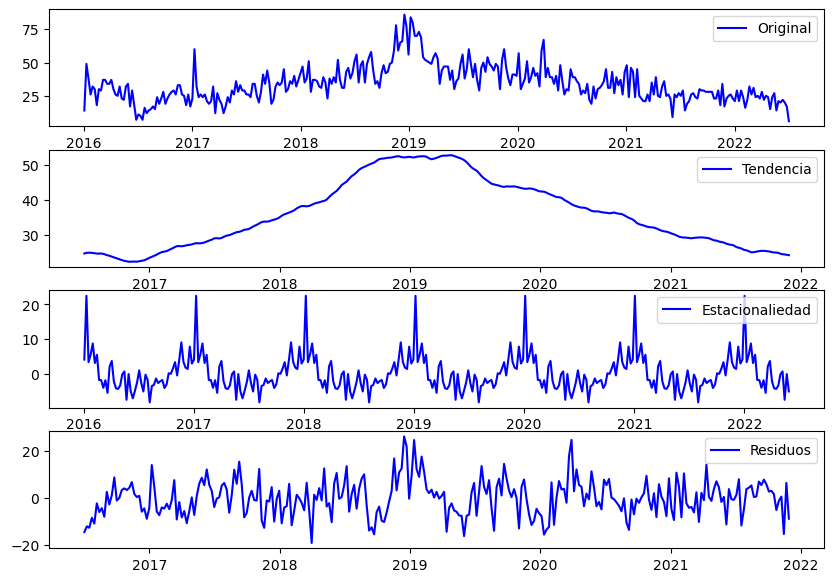

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2359.269, Time=3.45 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2473.570, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2417.007, Time=0.95 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2359.247, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2471.571, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2359.483, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2361.246, Time=2.88 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2359.240, Time=0.61 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2361.229, Time=3.11 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=10.85 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2472.948, Time=0.42 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2360.631, Time=0.90 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=2360.372, Time=0.75 sec
 ARIMA(1,1,2)(1,0,0)[52] int

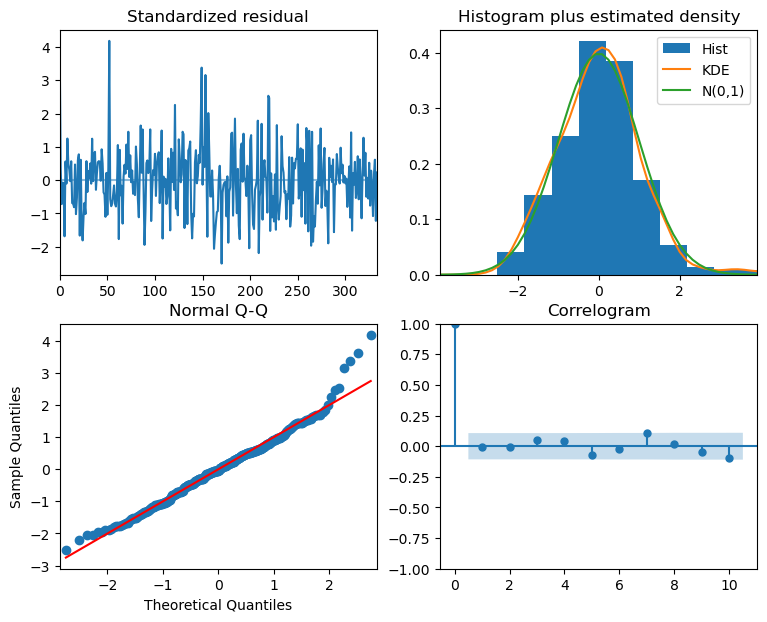

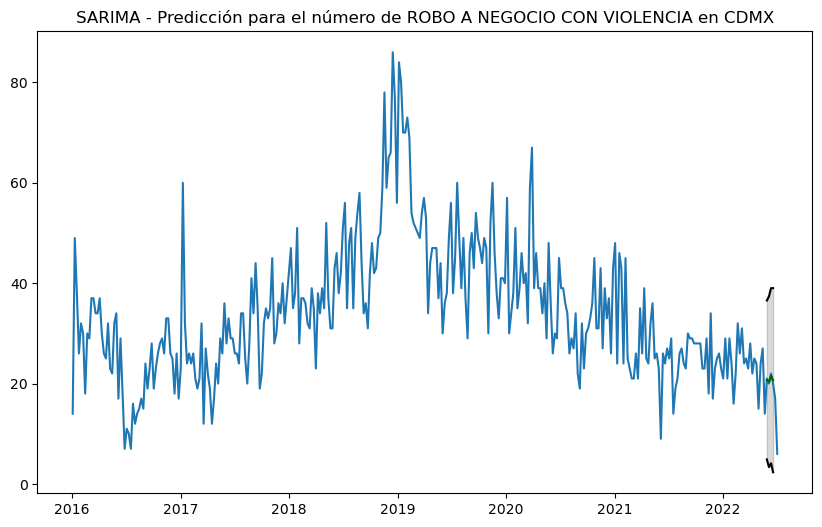

MAPE: 0.101189


In [28]:
model_plot(df_train = ts_train_robo_neg_con, n_periodos = 4, df_ori = robo_neg_con_x_sem, 
           categoria = "ROBO A NEGOCIO CON VIOLENCIA", df_test = ts_test_robo_neg_con)

## DELITOS SEXUALES

In [30]:
sexuales = pd.read_csv("../Data/sexuales.csv", parse_dates=["fecha_hechos"])
sexuales.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
sexuales.index = pd.DatetimeIndex(sexuales.fecha_hechos)

sexuales_x_sem = sexuales.resample("W", on = "fecha_hechos").size()
ts_train_sexuales=sexuales_x_sem[sexuales_x_sem.index<'2022-06']
ts_test_sexuales=sexuales_x_sem[sexuales_x_sem.index>='2022-06']

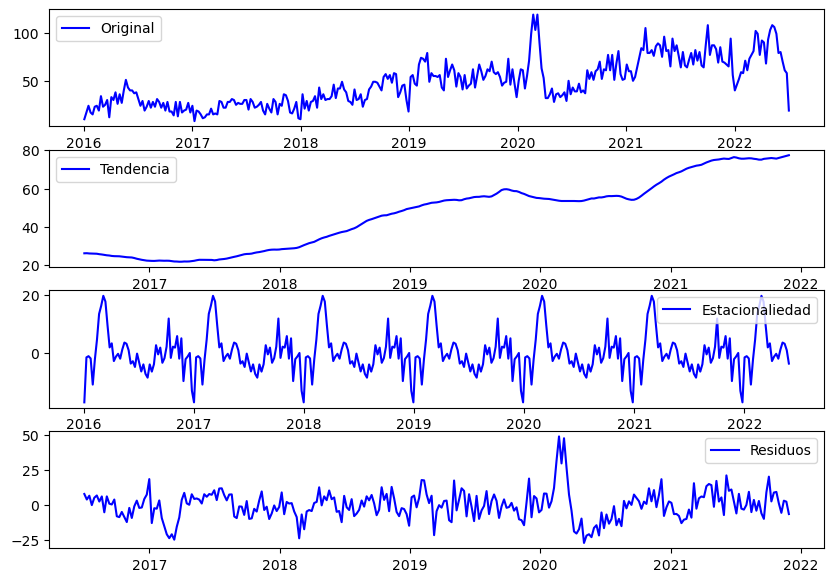

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=5.03 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3081.387, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2570.577, Time=0.97 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2775.518, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3617.920, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2583.150, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=2567.855, Time=4.98 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=2568.736, Time=10.10 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=2566.766, Time=3.32 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2566.521, Time=0.77 sec
 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=2566.780, Time=4.06 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=2568.738, Time=7.19 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=2540.009, Time=1.04 sec
 ARIMA(2,0,0)(0,0,0)[52] int

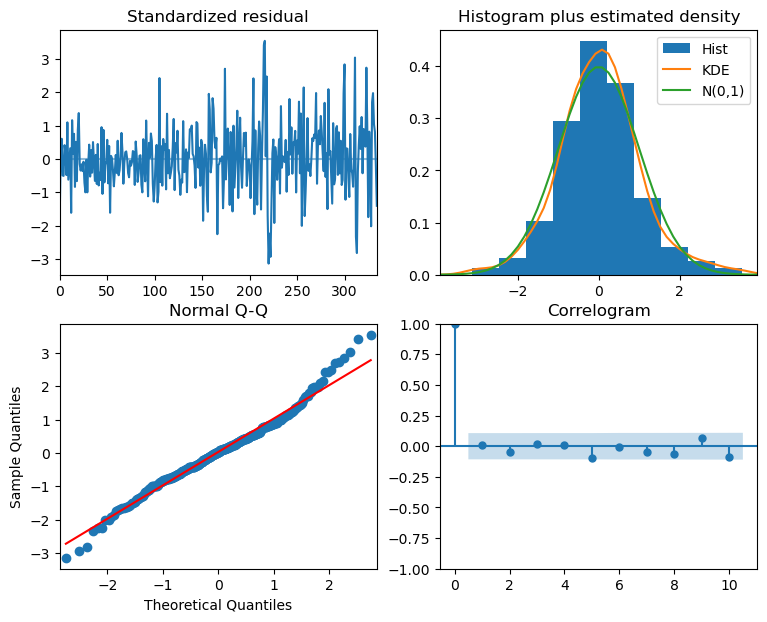

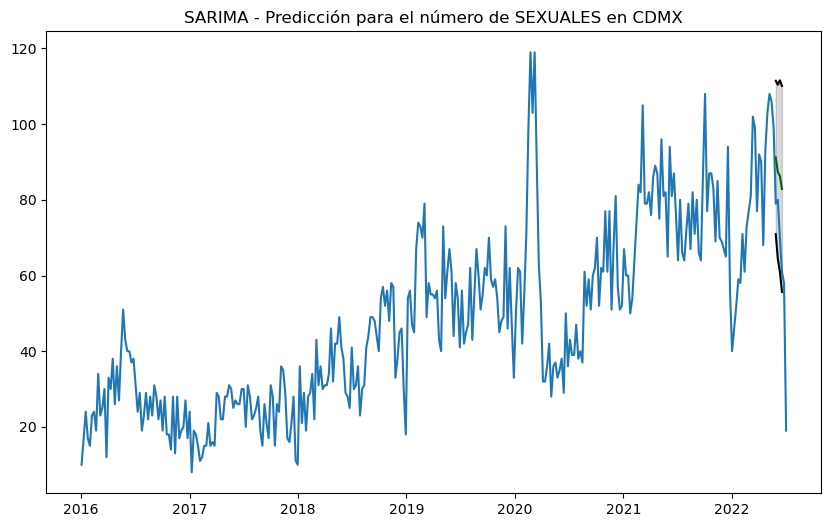

MAPE: 0.308040


In [31]:
model_plot(df_train = ts_train_sexuales, n_periodos = 4, df_ori = sexuales_x_sem, 
           categoria = "SEXUALES", df_test = ts_test_sexuales)

## ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA

In [32]:
robo_pasajeros = pd.read_csv("../Data/robo_pasajeros.csv", parse_dates=["fecha_hechos"])
robo_pasajeros.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_pasajeros.index = pd.DatetimeIndex(robo_pasajeros.fecha_hechos)

robo_pasajeros_x_sem = robo_pasajeros.resample("W", on = "fecha_hechos").size()
ts_train_robo_pasajeros=robo_pasajeros_x_sem[robo_pasajeros_x_sem.index<'2022-06']
ts_test_robo_pasajeros=robo_pasajeros_x_sem[robo_pasajeros_x_sem.index>='2022-06']

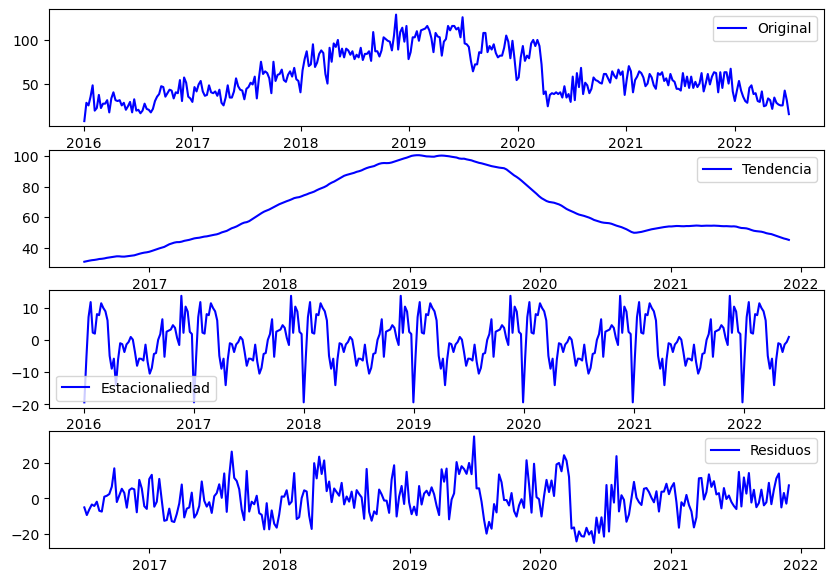

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.91 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2652.032, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2592.608, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2570.709, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2650.039, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2569.509, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2570.444, Time=0.64 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=3.52 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2569.313, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2570.853, Time=0.93 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=2570.973, Time=0.89 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=3.65 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2591.890, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=2568.046, Time=0.14 sec
 ARIMA(2,1,1)(1,0,0)[52] intercept

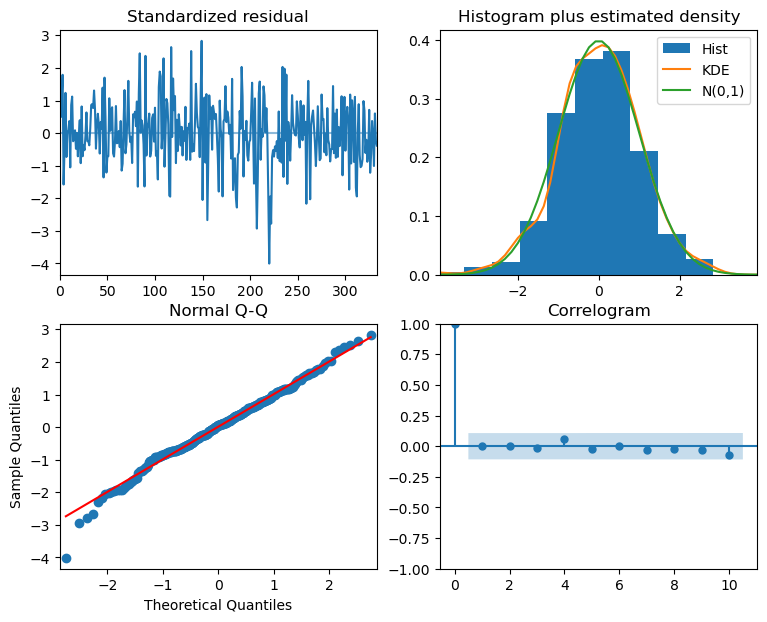

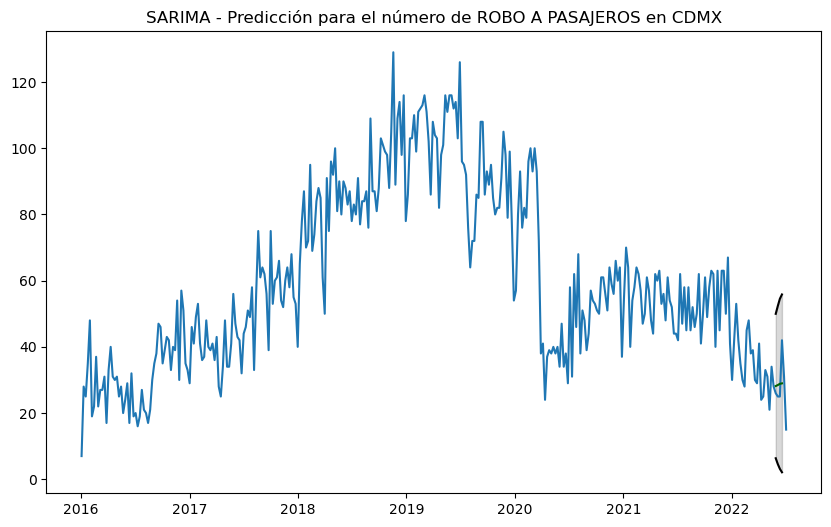

MAPE: 0.161033


In [33]:
model_plot(df_train = ts_train_robo_pasajeros, n_periodos = 4, df_ori = robo_pasajeros_x_sem, 
           categoria = "ROBO A PASAJEROS", df_test = ts_test_robo_pasajeros)

## ROBO A CASA SIN VIOLENCIA

In [34]:
robo_casa_sin = pd.read_csv("../Data/robo_casa_sin.csv", parse_dates=["fecha_hechos"])
robo_casa_sin.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_casa_sin.index = pd.DatetimeIndex(robo_casa_sin.fecha_hechos)

robo_casa_sin_x_sem = robo_casa_sin.resample("W", on = "fecha_hechos").size()
ts_train_robo_casa_sin=robo_casa_sin_x_sem[robo_casa_sin_x_sem.index<'2022-06']
ts_test_robo_casa_sin=robo_casa_sin_x_sem[robo_casa_sin_x_sem.index>='2022-06']

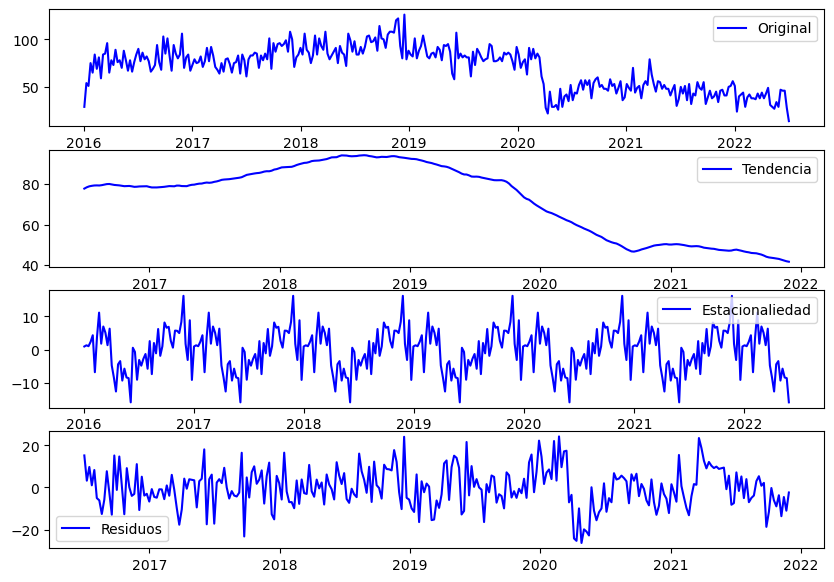

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.50 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2673.351, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2580.770, Time=0.85 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2540.093, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2671.351, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2538.363, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2540.054, Time=0.61 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2539.617, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=2539.668, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2578.927, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=2541.554, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=2536.479, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=2538.160, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[52]     

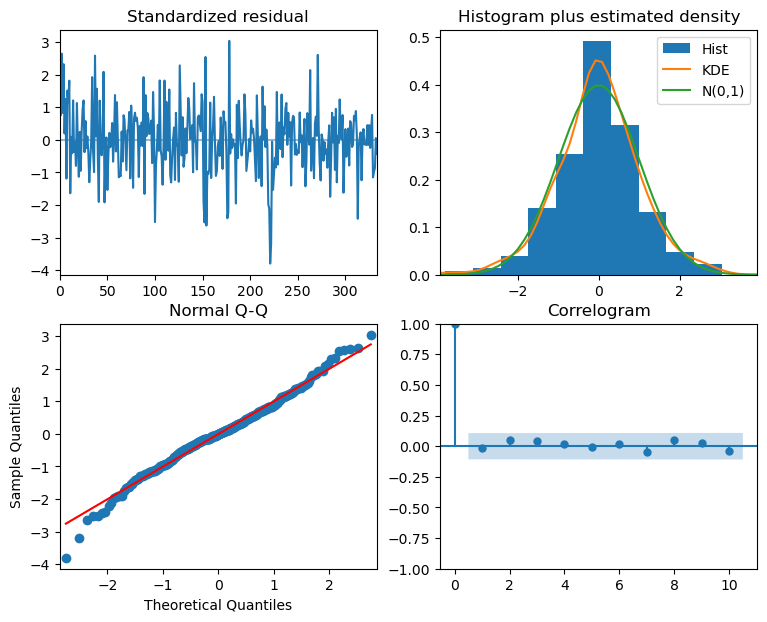

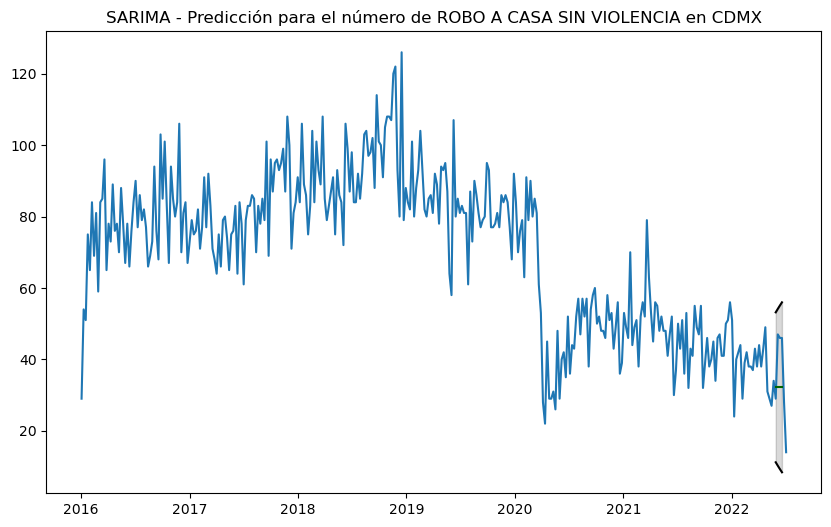

MAPE: 0.266340


In [35]:
model_plot(df_train = ts_train_robo_casa_sin, n_periodos = 4, df_ori = robo_casa_sin_x_sem, 
           categoria = "ROBO A CASA SIN VIOLENCIA", df_test = ts_test_robo_casa_sin)

## ROBO DE VEHICULO CON Y SIN VIOLENCIA

In [36]:
robo_carros = pd.read_csv("../Data/robo_carros.csv", parse_dates=["fecha_hechos"])
robo_carros.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_carros.index = pd.DatetimeIndex(robo_carros.fecha_hechos)

robo_carros_x_sem = robo_carros.resample("W", on = "fecha_hechos").size()
ts_train_robo_carros=robo_carros_x_sem[robo_carros_x_sem.index<'2022-06']
ts_test_robo_carros=robo_carros_x_sem[robo_carros_x_sem.index>='2022-06']

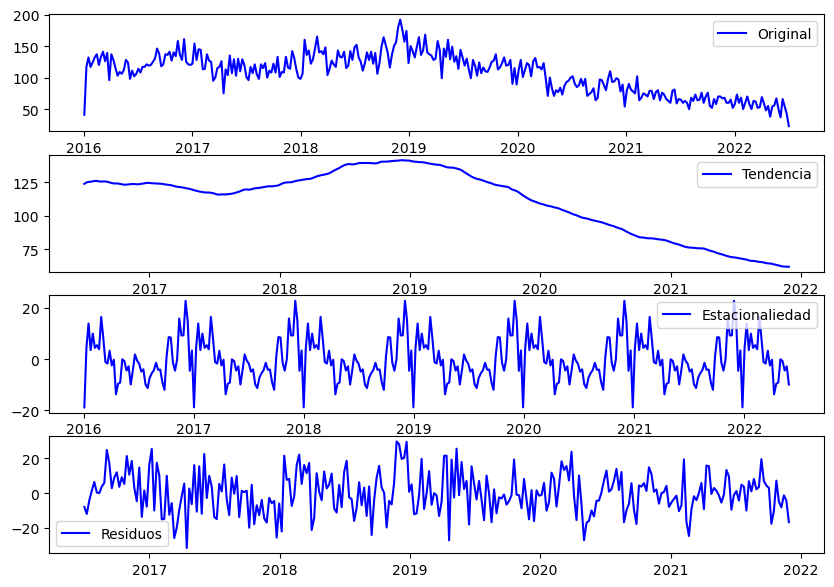

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.48 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2857.050, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2788.358, Time=0.91 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2743.702, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2855.051, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2747.307, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2743.946, Time=3.56 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2742.817, Time=0.67 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2742.371, Time=4.11 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=13.81 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=2856.546, Time=2.51 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=2743.417, Time=4.39 sec
 ARIMA(0,1,2)(2,0,0)[52] intercept   : AIC=2743.555, Time=4.68 sec
 ARIMA(1,1,0)(2,0,0)[52] intercep

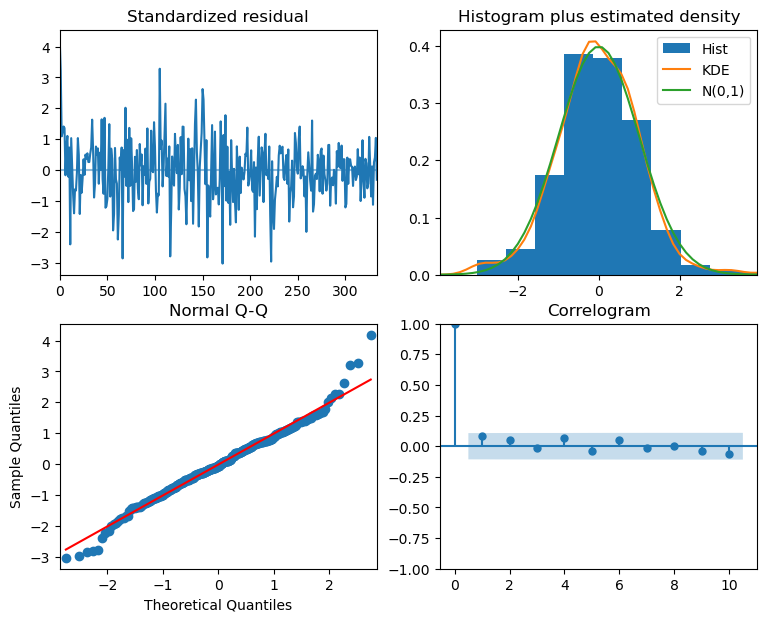

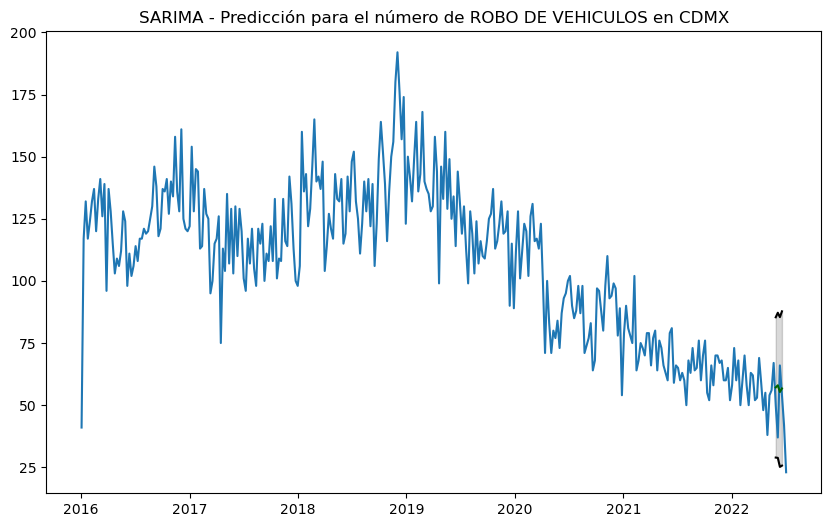

MAPE: 0.260105


In [37]:
model_plot(df_train = ts_train_robo_carros, n_periodos = 4, df_ori = robo_carros_x_sem, 
           categoria = "ROBO DE VEHICULOS", df_test = ts_test_robo_carros)

## AMENAZAS

In [38]:
amenazas = pd.read_csv("../Data/amenazas.csv", parse_dates=["fecha_hechos"])
amenazas.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
amenazas.index = pd.DatetimeIndex(amenazas.fecha_hechos)

amenazas_x_sem = amenazas.resample("W", on = "fecha_hechos").size()
ts_train_amenazas=amenazas_x_sem[amenazas_x_sem.index<'2022-06']
ts_test_amenazas=amenazas_x_sem[amenazas_x_sem.index>='2022-06']

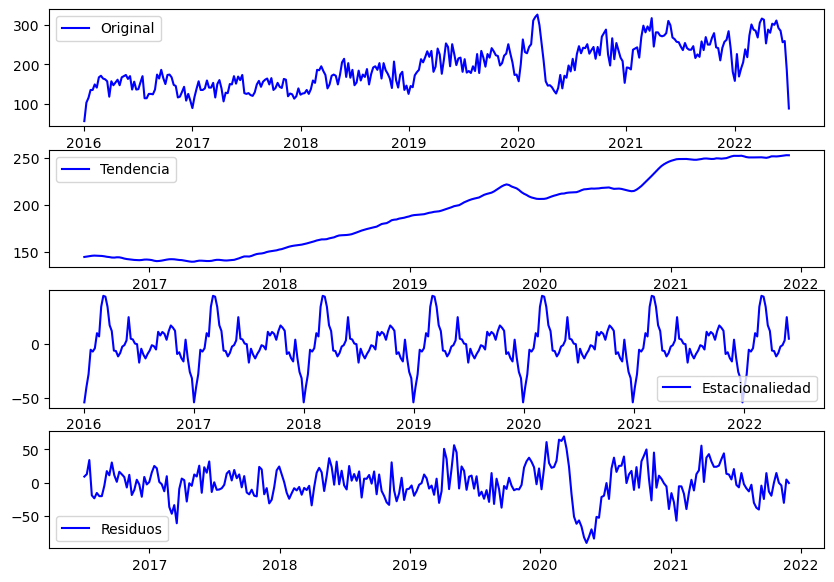

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3086.996, Time=4.74 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3627.290, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3106.927, Time=1.39 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3343.701, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4504.391, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3087.455, Time=2.44 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3086.360, Time=3.60 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3094.840, Time=0.22 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3087.504, Time=16.34 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=3089.605, Time=18.10 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3084.585, Time=2.27 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=3093.287, Time=0.15 sec
 ARIMA(1,0,2)(2,0,0)[52] intercept   : AIC=3085.729, Time=11.76 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=3084.915, Time=3.97 sec
 ARIMA(1,0,2)(0,

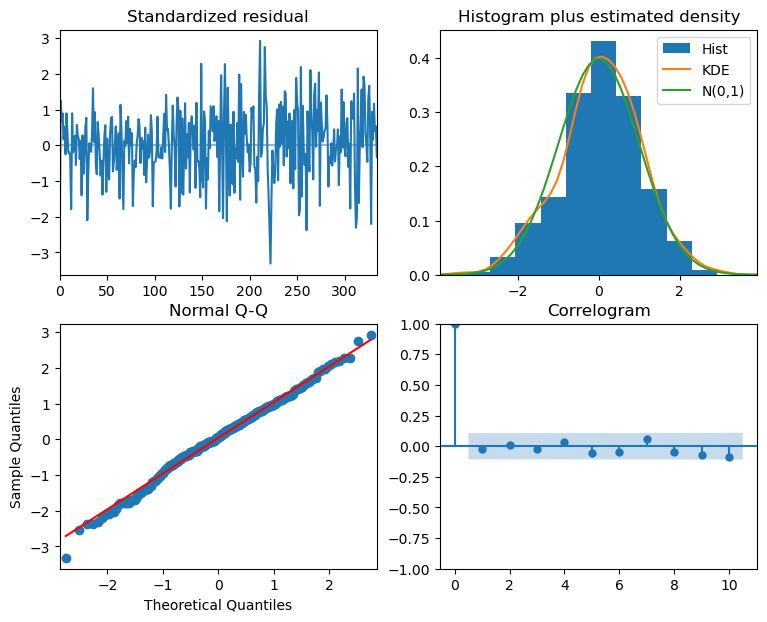

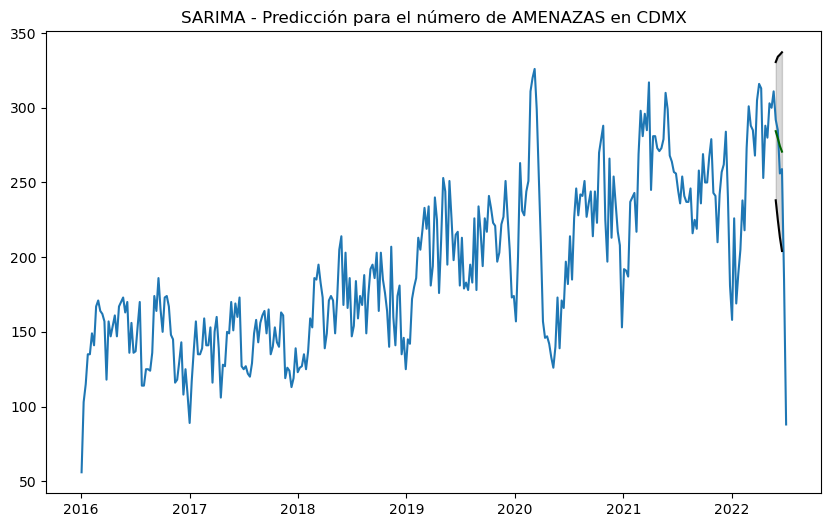

MAPE: 0.154228


In [39]:
model_plot(df_train = ts_train_amenazas, n_periodos = 4, df_ori = amenazas_x_sem, 
           categoria = "AMENAZAS", df_test = ts_test_amenazas)

## ROBO A NEGOCIO SIN VIOLENCIA

In [40]:
robo_neg_sin = pd.read_csv("../Data/robo_neg_sin.csv", parse_dates=["fecha_hechos"])
robo_neg_sin.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_neg_sin.index = pd.DatetimeIndex(robo_neg_sin.fecha_hechos)

robo_neg_sin_x_sem = robo_neg_sin.resample("W", on = "fecha_hechos").size()
ts_train_robo_neg_sin=robo_neg_sin_x_sem[robo_neg_sin_x_sem.index<'2022-06']
ts_test_robo_neg_sin=robo_neg_sin_x_sem[robo_neg_sin_x_sem.index>='2022-06']

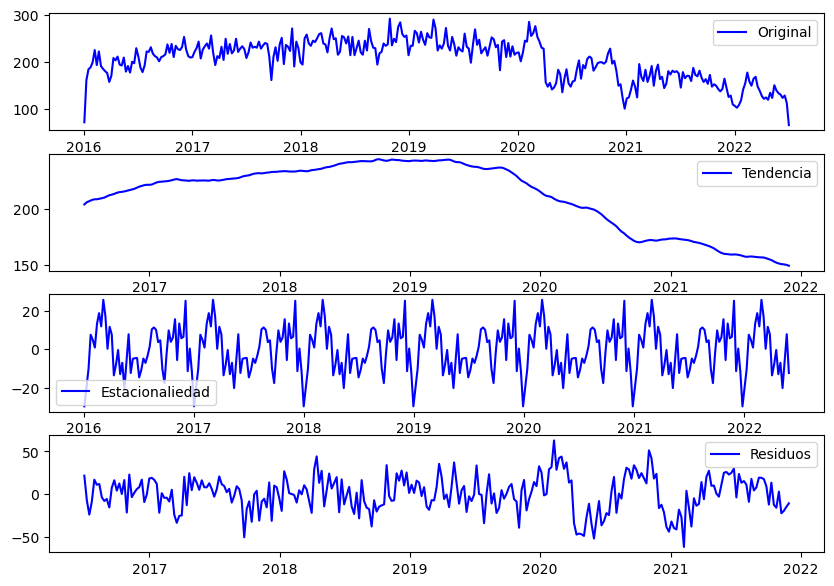

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3049.242, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3002.972, Time=1.07 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2988.003, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3047.263, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2991.755, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2984.498, Time=3.94 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=2985.107, Time=7.06 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=3046.442, Time=5.43 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=2983.782, Time=6.02 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=2987.626, Time=1.15 sec
 ARIMA(1,1,1)(1,0,2)[52] intercept   : AIC=2984.722, Time=10.32 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(1,1,0)(0,0,2)[52] intercep

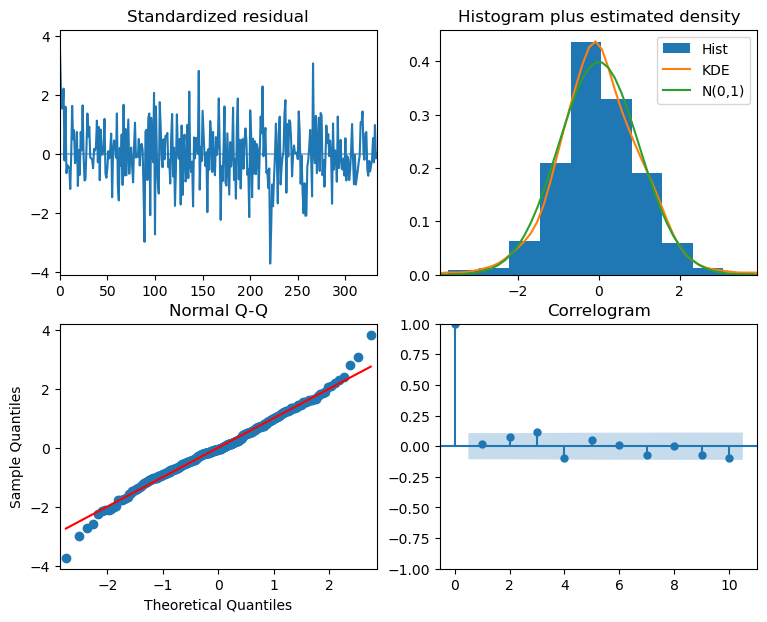

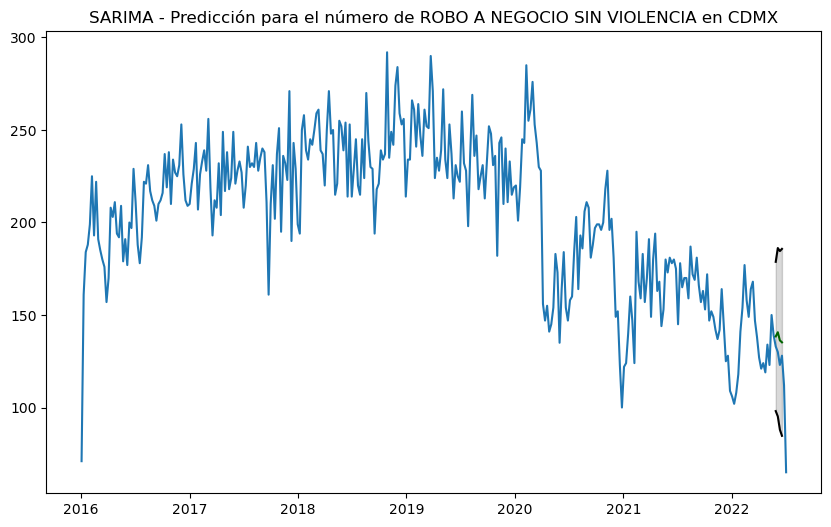

MAPE: 0.120149


In [41]:
model_plot(df_train = ts_train_robo_neg_sin, n_periodos = 4, df_ori = robo_neg_sin_x_sem, 
           categoria = "ROBO A NEGOCIO SIN VIOLENCIA", df_test = ts_test_robo_neg_sin)

## FRAUDE

In [42]:
fraude = pd.read_csv("../Data/fraude.csv", parse_dates=["fecha_hechos"])
fraude.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
fraude.index = pd.DatetimeIndex(fraude.fecha_hechos)

fraude_x_sem = fraude.resample("W", on = "fecha_hechos").size()
ts_train_fraude=fraude_x_sem[fraude_x_sem.index<'2022-06']
ts_test_fraude=fraude_x_sem[fraude_x_sem.index>='2022-06']

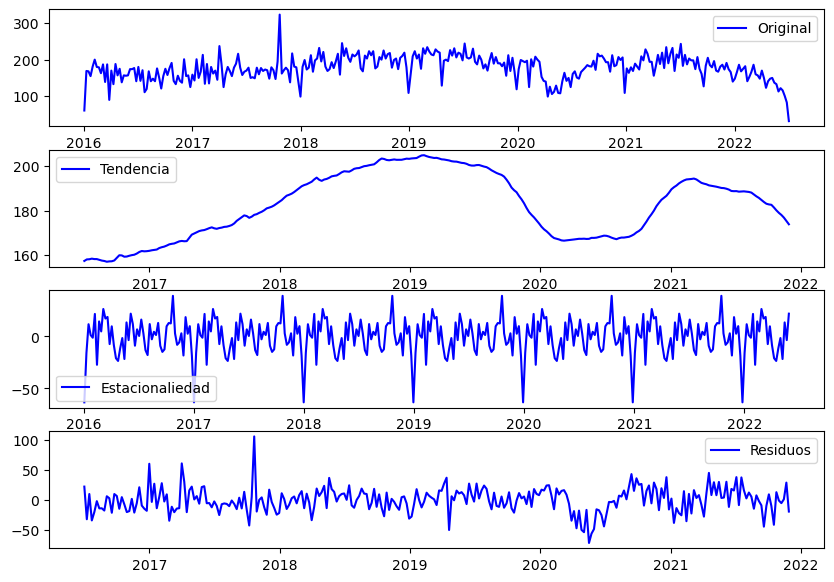

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=3101.089, Time=4.23 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3292.869, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3163.794, Time=0.91 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3123.337, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3290.876, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=3129.316, Time=2.09 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=3117.049, Time=3.51 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=3099.713, Time=19.47 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=3099.692, Time=15.45 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept   : AIC=3097.774, Time=8.59 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=3114.396, Time=1.73 sec
 ARIMA(1,1,2)(2,0,1)[52] intercept   : AIC=3097.859, Time=11.83 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=3099.046, Time=2.36 sec
 ARIMA(0,1,2)(2,0,0)[52] intercept   : AIC=3096.294, Time=5.22 sec
 ARIMA(0,1,2)(1,

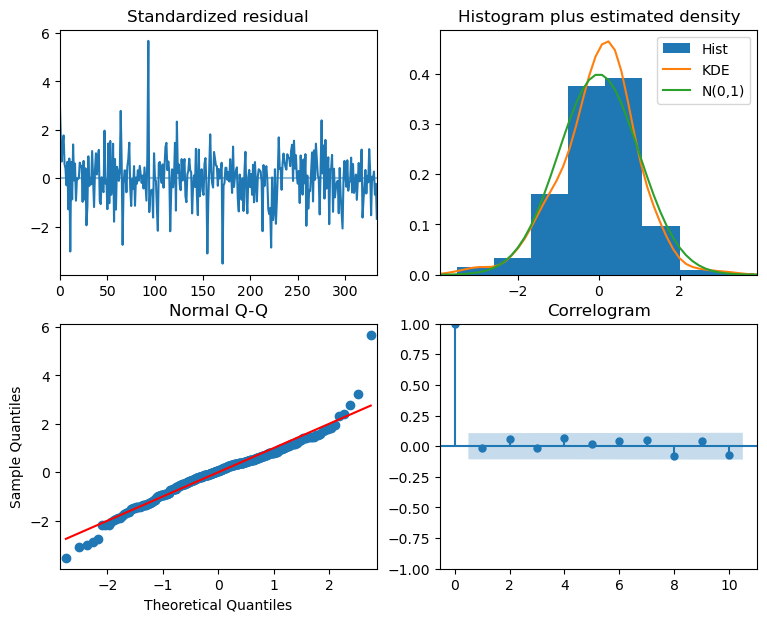

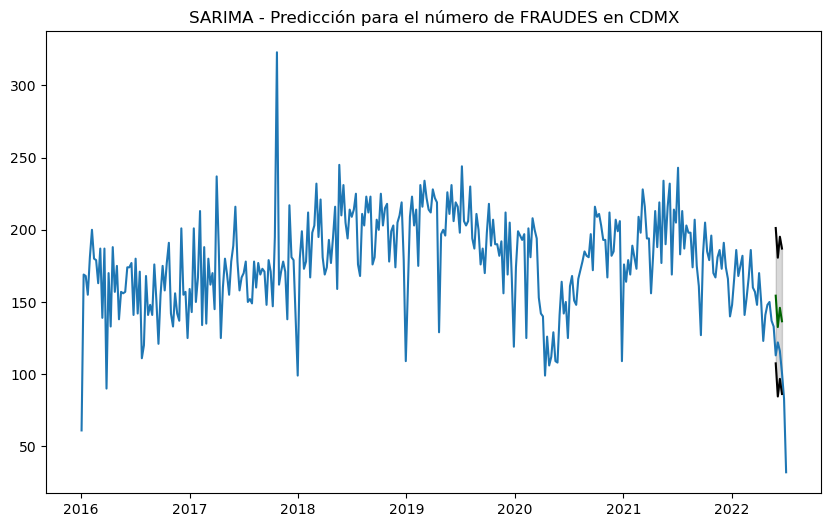

MAPE: 0.374907


In [43]:
model_plot(df_train = ts_train_fraude, n_periodos = 4, df_ori = fraude_x_sem, 
           categoria = "FRAUDES", df_test = ts_test_fraude)

## ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA

In [44]:
robo_transeuntes = pd.read_csv("../Data/robo_transeuntes.csv", parse_dates=["fecha_hechos"])
robo_transeuntes.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_transeuntes.index = pd.DatetimeIndex(robo_transeuntes.fecha_hechos)

robo_transeuntes_x_sem = robo_transeuntes.resample("W", on = "fecha_hechos").size()
ts_train_robo_transeuntes=robo_transeuntes_x_sem[robo_transeuntes_x_sem.index<'2022-06']
ts_test_robo_transeuntes=robo_transeuntes_x_sem[robo_transeuntes_x_sem.index>='2022-06']

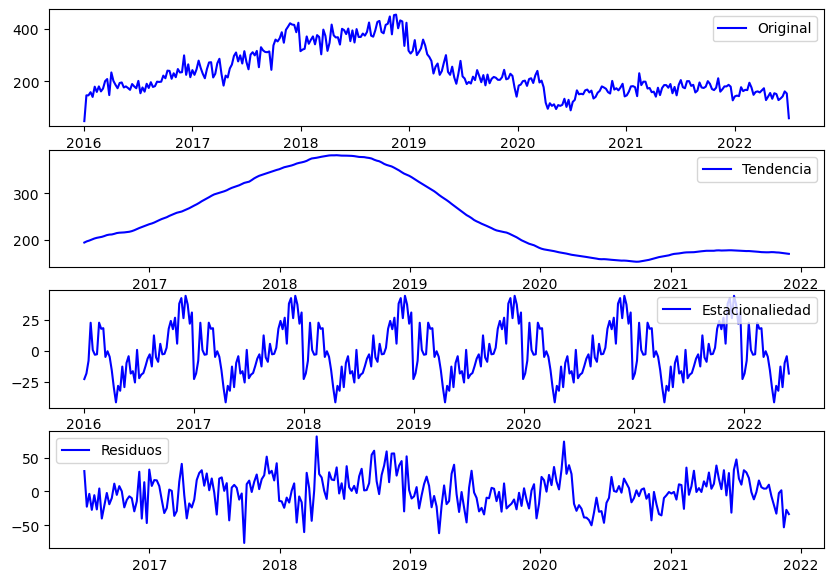

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3259.212, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3200.143, Time=1.02 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3170.342, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3257.231, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=3172.519, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=3172.223, Time=4.29 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=3170.157, Time=0.75 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=3171.909, Time=4.47 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=16.27 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=3258.830, Time=0.28 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=3172.118, Time=1.15 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=3172.110, Time=1.11 sec
 ARIMA(1,1,2)(1,0,0)[52] intercep

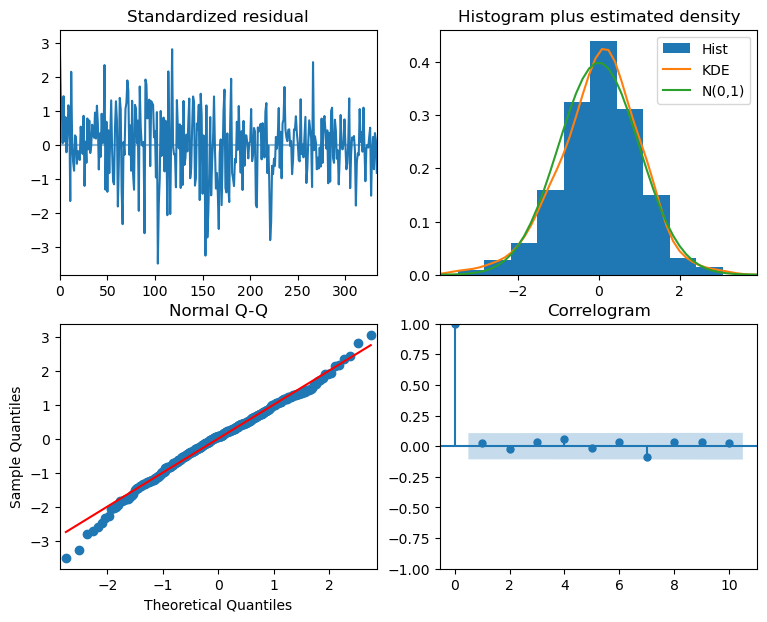

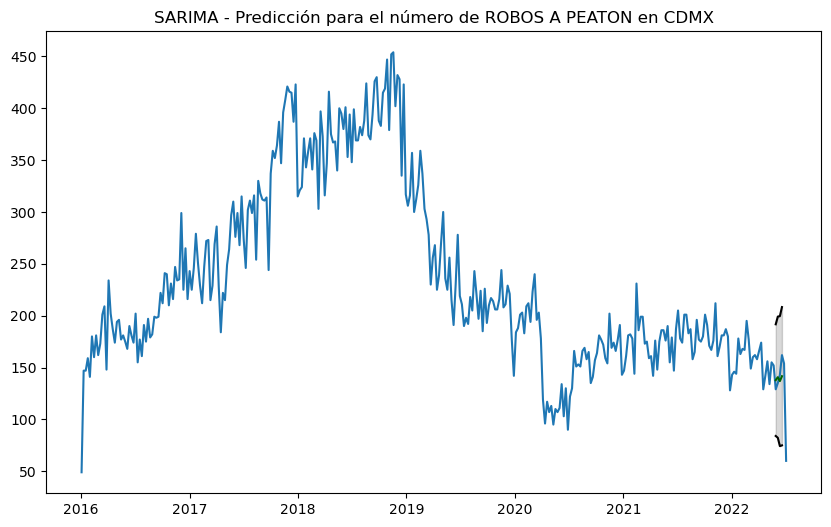

MAPE: 0.068119


In [45]:
model_plot(df_train = ts_train_robo_transeuntes, n_periodos = 4, df_ori = robo_transeuntes_x_sem, 
           categoria = "ROBOS A PEATON", df_test = ts_test_robo_transeuntes)

## VIOLENCIA FAMILIAR

In [46]:
violencia_familiar = pd.read_csv("../Data/violencia_familiar.csv", parse_dates=["fecha_hechos"])
violencia_familiar.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
violencia_familiar.index = pd.DatetimeIndex(violencia_familiar.fecha_hechos)

violencia_familiar_x_sem = violencia_familiar.resample("W", on = "fecha_hechos").size()
ts_train_violencia_familiar=violencia_familiar_x_sem[violencia_familiar_x_sem.index<'2022-06']
ts_test_violencia_familiar=violencia_familiar_x_sem[violencia_familiar_x_sem.index>='2022-06']

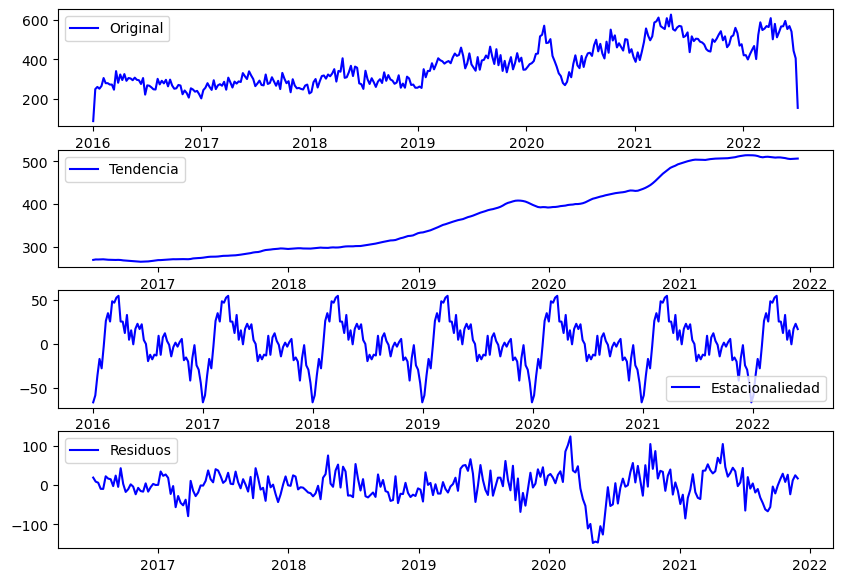

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.41 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4073.928, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3423.651, Time=1.26 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3762.719, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4943.505, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3421.917, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=3423.657, Time=1.18 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=3425.565, Time=1.18 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=3364.341, Time=0.14 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=3366.316, Time=1.93 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=3366.320, Time=1.63 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=3363.937, Time=0.19 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=3365.897, Time=2.57 sec
 ARIMA(3,0,0)(0,0,1)[52] inte

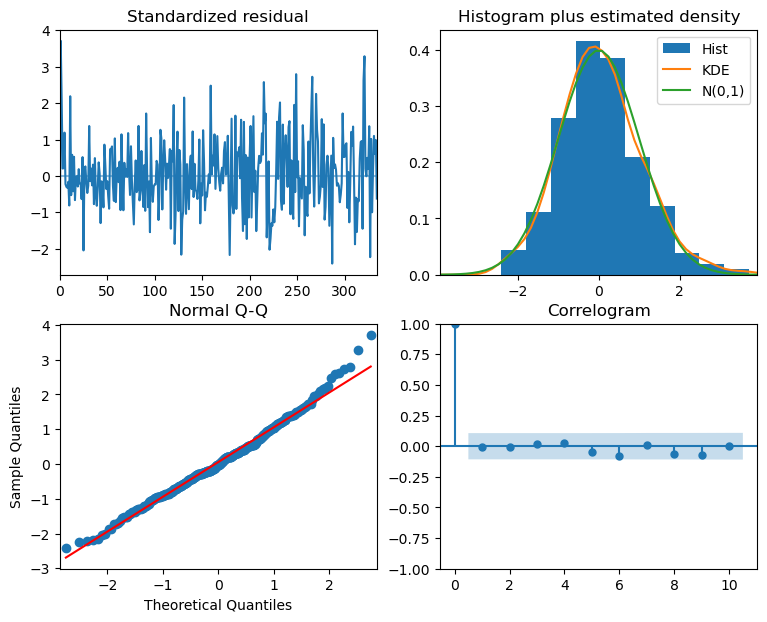

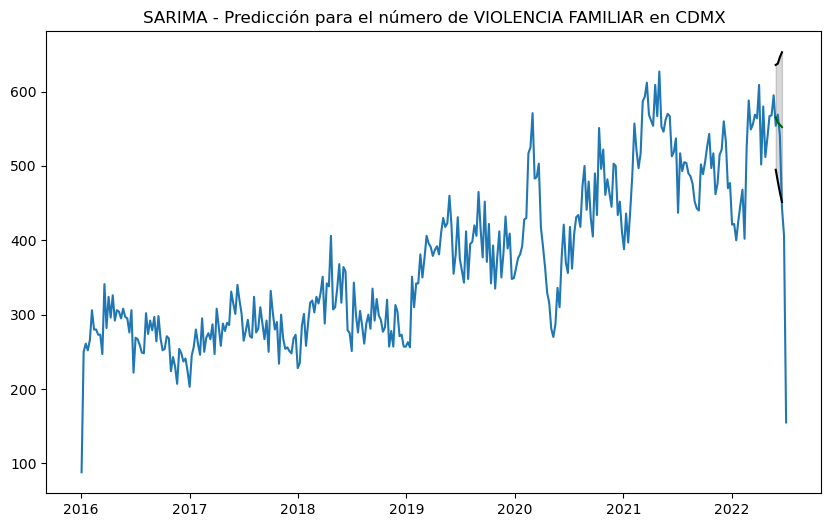

MAPE: 0.162415


In [47]:
model_plot(df_train = ts_train_violencia_familiar, n_periodos = 4, df_ori = violencia_familiar_x_sem, 
           categoria = "VIOLENCIA FAMILIAR", df_test = ts_test_violencia_familiar)

## ROBO DE OBJETOS

In [48]:
robo_objetos = pd.read_csv("../Data/robo_objetos.csv", parse_dates=["fecha_hechos"])
robo_objetos.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_objetos.index = pd.DatetimeIndex(robo_objetos.fecha_hechos)

robo_objetos_x_sem = robo_objetos.resample("W", on = "fecha_hechos").size()
ts_train_robo_objetos=robo_objetos_x_sem[robo_objetos_x_sem.index<'2022-06']
ts_test_robo_objetos=robo_objetos_x_sem[robo_objetos_x_sem.index>='2022-06']

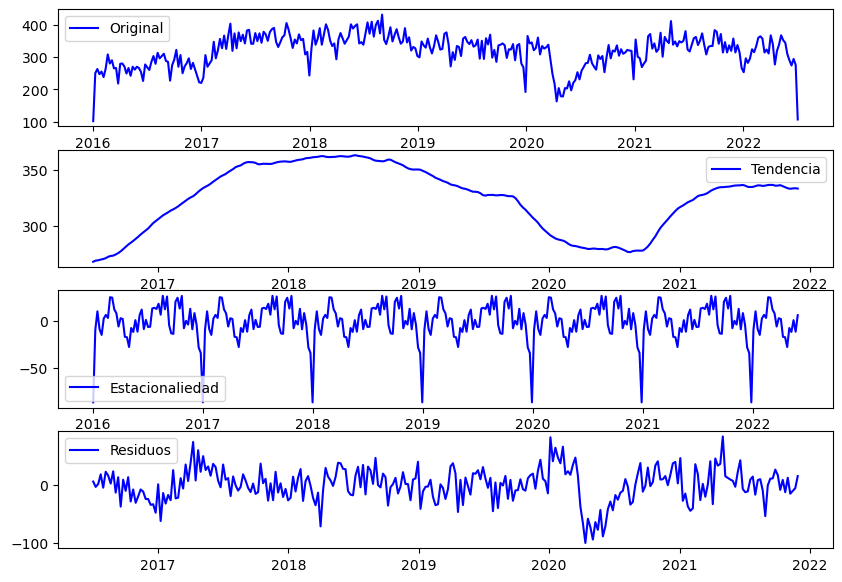

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.51 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3334.840, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3264.297, Time=0.97 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3246.284, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3332.942, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=3253.965, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=3242.110, Time=4.65 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=9.10 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=3332.595, Time=3.32 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=3243.871, Time=6.40 sec
 ARIMA(0,1,2)(0,0,2)[52] intercept   : AIC=3243.940, Time=5.64 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=3264.036, Time=3.34 sec
 ARIMA(1,1,2)(0,0,2)[52] intercept   : AIC=3244.989, Time=11.10 sec
 ARIMA(0,1,1)(0,0,2)[52]         

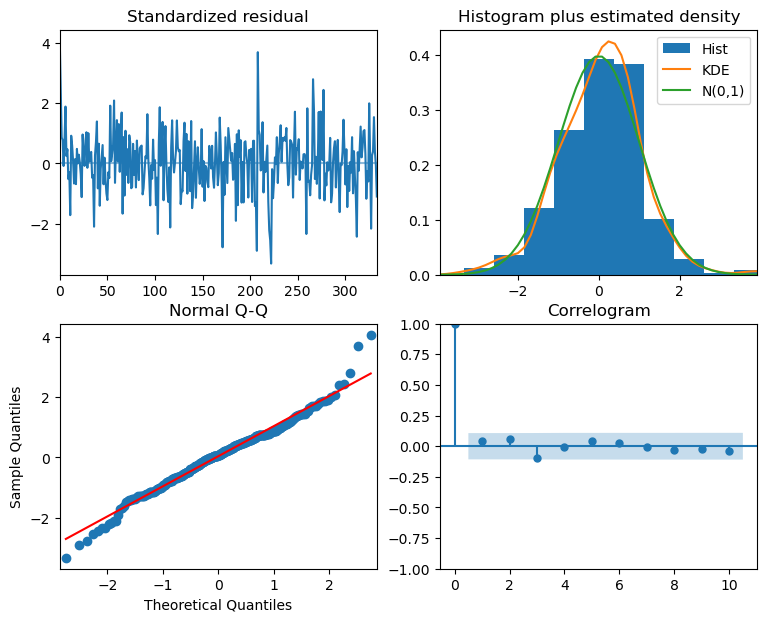

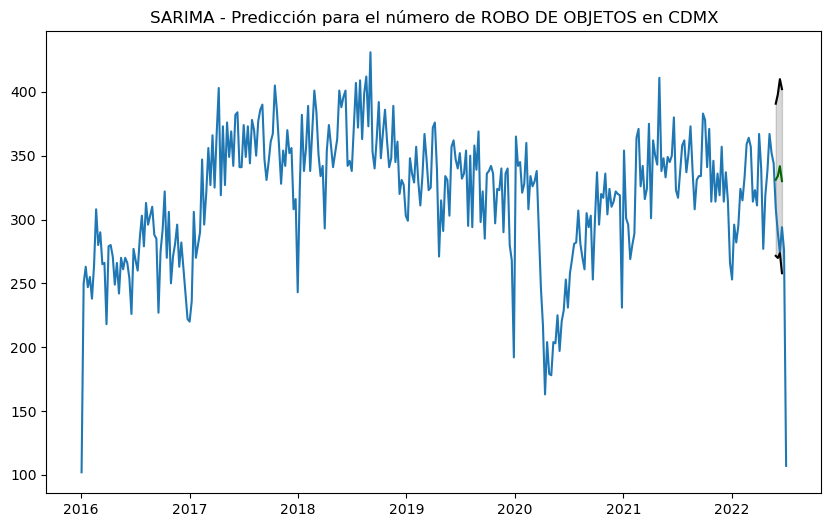

MAPE: 0.179736


In [49]:
model_plot(df_train = ts_train_robo_objetos, n_periodos = 4, df_ori = robo_objetos_x_sem, 
           categoria = "ROBO DE OBJETOS", df_test = ts_test_robo_objetos)